# EEG Classification Model

## Project Overview:
In this project, I built a classification model to analyze EEG data and classify it into different categories. EEG data is widely used in neuroscience and medical fields, including the diagnosis of epilepsy. I used two EEG datasets to train and evaluate my model.

## Dataset 
The dataset used contains EEG recordings from patients with epilepsy. It includes
various seizure types and non-seizure data
Link for the Dataset: https://physionet.org/content/chbmit/1.0.0/

# 1. Data Preprocessing:

### Function to read a single EDF file, extract, and split data into non-seizure and seizure segments


In [86]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import fft, rfft, rfftfreq
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM

import pyedflib
import pywt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def split_edf(file_path, seizure_start, seizure_end, pre_seizure_duration=10):
    with pyedflib.EdfReader(file_path) as edf:
        # Determine the sampling rate
        sampling_rate = edf.getSampleFrequencies()[0]
        
        # Calculate the indices for the non-seizure and seizure data
        pre_seizure_end_idx = int(seizure_start * sampling_rate)
        pre_seizure_start_idx = pre_seizure_end_idx - int(pre_seizure_duration * sampling_rate)
        seizure_end_idx = int(seizure_end * sampling_rate)
        
        # Read and split data for each channel
        non_seizure_data = [edf.readSignal(i)[pre_seizure_start_idx:pre_seizure_end_idx] for i in range(edf.signals_in_file)]
        seizure_data = [edf.readSignal(i)[pre_seizure_end_idx:seizure_end_idx] for i in range(edf.signals_in_file)]
        
        # Extract signal labels
        signal_labels = edf.getSignalLabels()
        
    return non_seizure_data, seizure_data, signal_labels

file_path = '/Users/archie/Desktop/FDA Project 3/DATASET/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf'

seizure_start_time = 2996
seizure_end_time = 3036

# Split the file into non-seizure and seizure parts
non_seizure_data, seizure_data, signal_labels = split_edf(file_path, seizure_start_time, seizure_end_time)

# Convert the split data into pandas DataFrames
df_non_seizure = pd.DataFrame(np.transpose(non_seizure_data), columns=signal_labels)
df_seizure = pd.DataFrame(np.transpose(seizure_data), columns=signal_labels)

In [3]:
# Replace with the paths where you want to save the CSV files
non_seizure_csv_path = '/Users/archie/Desktop/FDA Project 3 Data/Seizure and Non-Seizure/chb01/03non_seizure_data.csv'
seizure_csv_path = '/Users/archie/Desktop/FDA Project 3 Data/Seizure and Non-Seizure/chb01/03seizure_data.csv'

# Save the data to CSV
df_non_seizure.to_csv(non_seizure_csv_path, index=False)
df_seizure.to_csv(seizure_csv_path, index=False)

### Combining all the Seizure and Non Seizure Csv 

In [4]:

input_path = '/Users/archie/Desktop/FDA Project 3 Data/Seizure and Non-Seizure'

def concat_data(input_path):
    folders = os.listdir(input_path)
    df_seizure = pd.DataFrame()
    df_nonseizure = pd.DataFrame()
    i,j=0,0
    
    for folder in folders:
        if 'chb' in folder:
            files=os.listdir(input_path+'//'+folder)
            for file in files:
                file=file.lower()
                extension=os.path.splitext(file)[1]
                if extension=='.csv':
                    if 'non_seizure_data' in file:
                        data=pd.read_csv(input_path+'//'+folder+'//'+file)
                        df_nonseizure = pd.concat([df_nonseizure,data],ignore_index=True)
                        i+=1
                    else:
                        data=pd.read_csv(input_path+'//'+folder+'//'+file)
                        df_seizure=pd.concat([df_seizure,data],ignore_index=True)
                        j+=1
    print('The number of seizure files:',i)
    print('The number of non seizure files:',j)
    return df_seizure,df_nonseizure

                            
df_seizure,df_nonseizure=concat_data(input_path)

df_seizure['seizure']=1
df_nonseizure['seizure']=0

df_nonseizure.to_csv(input_path+'//'+'non_seizure_data.csv')
df_seizure.to_csv(input_path+'//'+'seizure_data.csv')

ch_labels = ['FP1-F7', 'C3-P3', 'C4-P4', 'CZ-PZ', 'F3-C3', 'F4-C4', 'F7-T7',
       'F8-T8', 'FP1-F3', 'FP2-F4', 'FP2-F8', 'FT10-T8', 'FT9-FT10', 'FZ-CZ',
       'P3-O1', 'P4-O2', 'P7-O1', 'P7-T7', 'P8-O2', 'T7-FT9', 'T7-P7',
       'T8-P8-0', 'T8-P8-1', 'seizure']

The number of seizure files: 196
The number of non seizure files: 196


In [6]:
# check columns in ch_labels
for cnt in ch_labels:
    if cnt not in df_seizure.columns:
        print(cnt)

T8-P8-0
T8-P8-1


In [7]:
# check columns in ch_labels
for cnt in ch_labels:
    if cnt not in df_nonseizure.columns:
        print(cnt)

T8-P8-0
T8-P8-1


In [8]:
# discarding irrelevant channels from df_seizure
df_seizure=df_seizure[df_seizure.columns[df_seizure.columns.isin(ch_labels)]]       

In [9]:
# discarding irrelevant channels from df_seizure
df_nonseizure=df_nonseizure[df_nonseizure.columns[df_nonseizure.columns.isin(ch_labels)]]       

In [10]:
df_seizure.isnull().sum()

FP1-F7      124416
F7-T7       124416
T7-P7       124416
P7-O1       124416
FP1-F3      124416
F3-C3       124416
C3-P3       124416
P3-O1       124416
FZ-CZ       124416
CZ-PZ       124416
FP2-F4      124416
F4-C4       124416
C4-P4       124416
P4-O2       124416
FP2-F8      124416
F8-T8       124416
P8-O2       124416
P7-T7       152576
T7-FT9      152576
FT9-FT10    152576
FT10-T8     152576
seizure          0
dtype: int64

In [11]:
df_nonseizure.isnull().sum()

FP1-F7      33280
F7-T7       33280
T7-P7       33280
P7-O1       33280
FP1-F3      33280
F3-C3       33280
C3-P3       33280
P3-O1       33280
FZ-CZ       33280
CZ-PZ       33280
FP2-F4      33280
F4-C4       33280
C4-P4       33280
P4-O2       33280
FP2-F8      33280
F8-T8       33280
P8-O2       33280
P7-T7       43520
T7-FT9      43520
FT9-FT10    43520
FT10-T8     43520
seizure         0
dtype: int64

In [12]:
df_seizure.interpolate(method='linear', axis=0, inplace=True)

In [13]:
df_seizure.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FZ-CZ,CZ-PZ,...,C4-P4,P4-O2,FP2-F8,F8-T8,P8-O2,P7-T7,T7-FT9,FT9-FT10,FT10-T8,seizure
0,31.452991,-100.610501,-2.930403,4.102564,9.181929,-23.247863,-42.393162,-9.963370,5.665446,-57.631258,...,-41.221001,-34.188034,-90.061050,44.737485,-27.545788,3.321123,68.962149,-81.074481,34.578755,1
1,40.048840,-100.610501,-12.698413,12.698413,0.195360,-24.420024,-38.485958,3.711844,2.539683,-52.551893,...,-40.048840,-24.420024,-114.676435,64.664225,-18.949939,13.089133,84.590965,-87.326007,18.168498,1
2,36.141636,-87.716728,-18.949939,26.373626,-0.586081,-27.155067,-32.625153,18.559219,-2.148962,-37.704518,...,-22.075702,-12.698413,-84.590965,49.035409,-14.261294,19.340659,94.358974,-74.432234,-0.195360,1
3,43.565324,-84.981685,-2.539683,16.214896,-3.711844,-25.982906,-22.075702,25.982906,-10.354090,-31.452991,...,-22.466422,-9.963370,-82.246642,40.048840,-8.400488,2.930403,91.623932,-71.306471,-11.916972,1
4,57.631258,-96.312576,4.884005,20.122100,-6.446886,-29.890110,-15.433455,40.830281,-14.652015,-23.247863,...,-8.009768,0.195360,-5.665446,-32.234432,-0.195360,-4.493284,109.987790,-75.995116,-24.810745,1


In [14]:
df_nonseizure.interpolate(method='linear', axis=0, inplace=True)

In [15]:
df_nonseizure.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FZ-CZ,CZ-PZ,...,C4-P4,P4-O2,FP2-F8,F8-T8,P8-O2,P7-T7,T7-FT9,FT9-FT10,FT10-T8,seizure
0,-29.890110,-1.367521,1.367521,60.757021,1.758242,-9.572650,10.354090,26.764347,3.321123,9.572650,...,0.586081,-1.758242,10.744811,-25.592186,34.188034,-0.976801,13.870574,45.518926,-37.704518,0
1,-35.750916,-16.214896,2.539683,70.525031,1.367521,-18.559219,8.400488,27.545788,-4.102564,9.572650,...,0.195360,0.195360,7.619048,-33.015873,39.267399,-2.148962,27.936508,48.253968,-50.207570,0
2,-33.797314,-21.294261,1.367521,70.134310,4.102564,-23.247863,9.181929,24.420024,-10.744811,12.307692,...,-3.711844,-2.148962,0.195360,-2.148962,45.518926,-0.976801,22.466422,32.234432,-7.228327,0
3,-27.936508,-9.572650,-4.884005,58.412698,8.791209,-25.982906,12.307692,18.168498,-16.996337,16.996337,...,0.195360,-4.493284,-9.963370,11.135531,40.439560,5.274725,11.526252,22.857143,2.539683,0
4,-27.545788,-17.777778,3.711844,54.114774,4.493284,-24.810745,12.307692,18.949939,-20.512821,18.168498,...,-2.148962,-1.758242,-12.307692,14.261294,33.797314,-3.321123,24.029304,13.089133,2.539683,0


# 2. Feature Extraction:

In [16]:
# Define a function to calculate time-domain features
def extract_time_domain_features(signal):
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'variance': np.var(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'skewness': skew(signal),
        'kurtosis': kurtosis(signal)
    }
    return features

# Define a function to calculate frequency-domain features
def extract_frequency_domain_features(signal, fs):
    freqs, psd = welch(signal, fs=fs)
    bands = {'alpha': (8, 12), 'beta': (12, 30)}
    
    band_power = {}
    for band, (low_freq, high_freq) in bands.items():
        idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
        band_power[band] = np.trapz(psd[idx_band], freqs[idx_band])
    
    return band_power

In [17]:
# Assume a sampling frequency of 256Hz for the EEG data
fs = 256

In [18]:
# Apply the feature extraction functions
seizure_time_features = df_seizure.apply(extract_time_domain_features, axis=0)
seizure_freq_features = df_seizure.apply(extract_frequency_domain_features, axis=0, fs=fs)

In [19]:
non_seizure_time_features = df_nonseizure.apply(extract_time_domain_features, axis=0)
non_seizure_freq_features = df_nonseizure.apply(extract_frequency_domain_features, axis=0, fs=fs)

In [20]:
# Combine time and frequency domain features
seizure_features = pd.concat([seizure_time_features, seizure_freq_features], axis=1)
non_seizure_features = pd.concat([non_seizure_time_features, non_seizure_freq_features], axis=1)

In [21]:
# Flatten the dictionaries in each row into separate columns
seizure_time_features = seizure_time_features.apply(pd.Series)
seizure_freq_features = seizure_freq_features.apply(pd.Series)

In [22]:
non_seizure_time_features = non_seizure_time_features.apply(pd.Series)
non_seizure_freq_features = non_seizure_freq_features.apply(pd.Series)

In [23]:
# Combine seizure and non-seizure data and add labels
seizure_features['seizure'] = 1
non_seizure_features['seizure'] = 0

In [24]:
final_df = pd.concat([seizure_features, non_seizure_features], ignore_index=True)

In [33]:
final_df

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FZ-CZ,CZ-PZ,...,C4-P4,P4-O2,FP2-F8,F8-T8,P8-O2,P7-T7,T7-FT9,FT9-FT10,FT10-T8,seizure
0,31.452991,-100.610501,-2.930403,4.102564,9.181929,-23.247863,-42.393162,-9.963370,5.665446,-57.631258,...,-41.221001,-34.188034,-90.061050,44.737485,-27.545788,3.321123,68.962149,-81.074481,34.578755,1
1,40.048840,-100.610501,-12.698413,12.698413,0.195360,-24.420024,-38.485958,3.711844,2.539683,-52.551893,...,-40.048840,-24.420024,-114.676435,64.664225,-18.949939,13.089133,84.590965,-87.326007,18.168498,1
2,36.141636,-87.716728,-18.949939,26.373626,-0.586081,-27.155067,-32.625153,18.559219,-2.148962,-37.704518,...,-22.075702,-12.698413,-84.590965,49.035409,-14.261294,19.340659,94.358974,-74.432234,-0.195360,1
3,43.565324,-84.981685,-2.539683,16.214896,-3.711844,-25.982906,-22.075702,25.982906,-10.354090,-31.452991,...,-22.466422,-9.963370,-82.246642,40.048840,-8.400488,2.930403,91.623932,-71.306471,-11.916972,1
4,57.631258,-96.312576,4.884005,20.122100,-6.446886,-29.890110,-15.433455,40.830281,-14.652015,-23.247863,...,-8.009768,0.195360,-5.665446,-32.234432,-0.195360,-4.493284,109.987790,-75.995116,-24.810745,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426811,-113.504274,82.246642,113.504274,-148.669109,-6.837607,-81.465201,44.737485,-22.466422,16.605617,-22.075702,...,-36.923077,-22.466422,-13.479853,40.830281,-83.028083,-113.113553,-67.789988,88.107448,11.526252,0
3426812,-104.126984,32.625153,137.338217,-134.993895,-63.882784,-22.075702,35.360195,-17.777778,19.731380,-20.122100,...,-32.625153,-24.420024,-15.433455,43.174603,-99.829060,-136.947497,-30.671551,95.140415,23.247863,0
3426813,-92.014652,-3.321123,113.504274,-97.875458,-39.267399,-37.704518,20.122100,-22.466422,28.717949,-15.824176,...,-26.764347,-13.870574,-21.684982,10.354090,-113.894994,-113.113553,11.916972,91.623932,-0.586081,0
3426814,-68.571429,-24.029304,86.153846,-74.432234,-39.267399,-19.731380,16.214896,-39.658120,28.327228,-17.387057,...,-23.247863,-8.791209,-27.936508,4.884005,-101.391941,-85.763126,34.969475,83.028083,-4.102564,0


# 3. Data Splitting:

In [25]:
# Define the features (X) and labels (y)
X = final_df.drop('seizure', axis=1)  
y = final_df['seizure']

In [26]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (30, 2)
Validation set shape: (7, 2)
Test set shape: (7, 2)


In [28]:
# Combine seizure and non-seizure data
df_seizure['seizure'] = 1
df_nonseizure['seizure'] = 0

In [29]:
final_df = pd.concat([df_seizure, df_nonseizure], ignore_index=True)

In [30]:
# Define the features (X) and labels (y)
X = final_df.drop('seizure', axis=1).values  
y = final_df['seizure'].values 

In [35]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [36]:
# Reshape the data for LSTM input (assuming time series data)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [39]:
#CNN

In [59]:
# Split data into features (X) and labels (y)
X_cnn = final_df.drop('seizure', axis=1)
y_cnn = final_df['seizure']
 
# Split the data into training, validation, and test sets
X_train_cnn, X_temp_cnn, y_train_cnn, y_temp_cnn = train_test_split(X_cnn, y_cnn, test_size=0.3, random_state=42)
X_val_cnn, X_test_cnn, y_val_cnn, y_test_cnn = train_test_split(X_temp_cnn, y_temp_cnn, test_size=0.5, random_state=42)
 
# Reshape data for CNN [samples, timesteps, features]
X_train_cnn = X_train_cnn.values.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))
X_val_cnn = X_val_cnn.values.reshape((X_val_cnn.shape[0], X_val_cnn.shape[1], 1))
X_test_cnn = X_test_cnn.values.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))

# 4. Model Selection:

# Using BI-LTSM

In [41]:
# Create a Bi-LSTM model
model_dropout = Sequential()
model_dropout.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(1, X_train.shape[2])))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(1, activation='sigmoid'))

# Using CNN

In [60]:
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 5. Model Training:

# BI-LTSM

In [43]:
# Compile the model
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_dropout = model_dropout.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
74962/74962 [==============================] - 101s 1ms/step - loss: 0.3788 - accuracy: 0.8549 - val_loss: 0.3495 - val_accuracy: 0.8597
Epoch 2/10
74962/74962 [==============================] - 99s 1ms/step - loss: 0.3616 - accuracy: 0.8575 - val_loss: 0.3470 - val_accuracy: 0.8596
Epoch 3/10
74962/74962 [==============================] - 98s 1ms/step - loss: 0.3600 - accuracy: 0.8578 - val_loss: 0.3448 - val_accuracy: 0.8597
Epoch 4/10
74962/74962 [==============================] - 98s 1ms/step - loss: 0.3589 - accuracy: 0.8580 - val_loss: 0.3439 - val_accuracy: 0.8603
Epoch 5/10
74962/74962 [==============================] - 98s 1ms/step - loss: 0.3588 - accuracy: 0.8582 - val_loss: 0.3450 - val_accuracy: 0.8597
Epoch 6/10
74962/74962 [==============================] - 98s 1ms/step - loss: 0.3586 - accuracy: 0.8585 - val_loss: 0.3431 - val_accuracy: 0.8594
Epoch 7/10
74962/74962 [==============================] - 98s 1ms/step - loss: 0.3583 - accuracy: 0.8585 - val_loss: 

In [44]:
# Predictions on the validation set
y_val_pred = model_dropout.predict(X_val)
y_val_pred_binary = np.round(y_val_pred)

16064/16064 [==============================] - 8s 489us/step


# CNN

In [61]:
# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=64, validation_data=(X_val_cnn, y_val))

Epoch 1/10
37481/37481 [==============================] - 52s 1ms/step - loss: 0.3627 - accuracy: 0.8555 - val_loss: 0.3408 - val_accuracy: 0.8614
Epoch 2/10
37481/37481 [==============================] - 50s 1ms/step - loss: 0.3488 - accuracy: 0.8592 - val_loss: 0.3368 - val_accuracy: 0.8625
Epoch 3/10
37481/37481 [==============================] - 50s 1ms/step - loss: 0.3442 - accuracy: 0.8603 - val_loss: 0.3313 - val_accuracy: 0.8624
Epoch 4/10
37481/37481 [==============================] - 50s 1ms/step - loss: 0.3415 - accuracy: 0.8612 - val_loss: 0.3292 - val_accuracy: 0.8628
Epoch 5/10
37481/37481 [==============================] - 50s 1ms/step - loss: 0.3402 - accuracy: 0.8614 - val_loss: 0.3287 - val_accuracy: 0.8632
Epoch 6/10
37481/37481 [==============================] - 49s 1ms/step - loss: 0.3395 - accuracy: 0.8615 - val_loss: 0.3296 - val_accuracy: 0.8626
Epoch 7/10
37481/37481 [==============================] - 49s 1ms/step - loss: 0.3385 - accuracy: 0.8617 - val_loss: 0

# 6. Model Evaluation:

# BI-LTSM

In [45]:
# Evaluate performance on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred_binary)
confusion_matrix_val = confusion_matrix(y_val, y_val_pred_binary)
classification_report_val = classification_report(y_val, y_val_pred_binary)
 
print("Validation Set Performance:")
print(f"Accuracy: {accuracy_val:.4f}")
print("Confusion Matrix:")
print(confusion_matrix_val)
print("Classification Report:")
print(classification_report_val)

Validation Set Performance:
Accuracy: 0.8609
Confusion Matrix:
[[  3767  71380]
 [   120 438755]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.05      0.10     75147
           1       0.86      1.00      0.92    438875

    accuracy                           0.86    514022
   macro avg       0.91      0.52      0.51    514022
weighted avg       0.88      0.86      0.80    514022



# CNN

In [62]:
# Evaluate the model on the test set
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn)
print(f"Test accuracy: {test_accuracy_cnn * 100:.2f}%")

16064/16064 [==============================] - 8s 463us/step - loss: 0.3277 - accuracy: 0.8627
Test accuracy: 86.27%


# 7. Testing

We are using Bidirectional Long short term memory model

In [46]:
# Predictions on the test set
y_test_pred = model_dropout.predict(X_test)
y_test_pred_binary = np.round(y_test_pred)
 
# Evaluate performance on the test set
accuracy_test = accuracy_score(y_test, y_test_pred_binary)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred_binary)
classification_report_test = classification_report(y_test, y_test_pred_binary)
 
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_test:.4f}")
print("Confusion Matrix:")
print(confusion_matrix_test)
print("Classification Report:")
print(classification_report_test)

16064/16064 [==============================] - 8s 491us/step

Test Set Performance:
Accuracy: 0.8604
Confusion Matrix:
[[  3692  71620]
 [   136 438575]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.05      0.09     75312
           1       0.86      1.00      0.92    438711

    accuracy                           0.86    514023
   macro avg       0.91      0.52      0.51    514023
weighted avg       0.87      0.86      0.80    514023



# 8. Results and Visualization

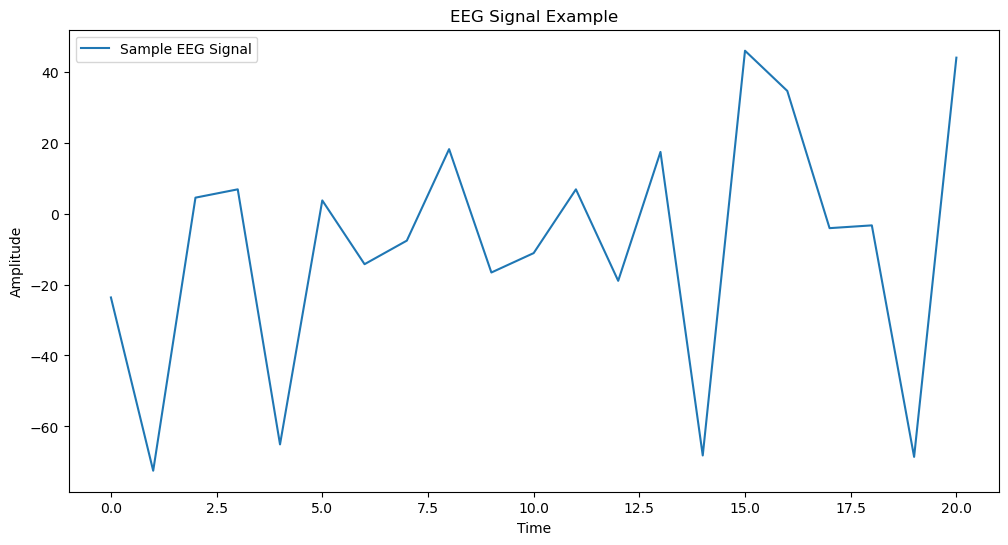

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(X_train[0].flatten(), label='Sample EEG Signal')
plt.title('EEG Signal Example')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [64]:
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

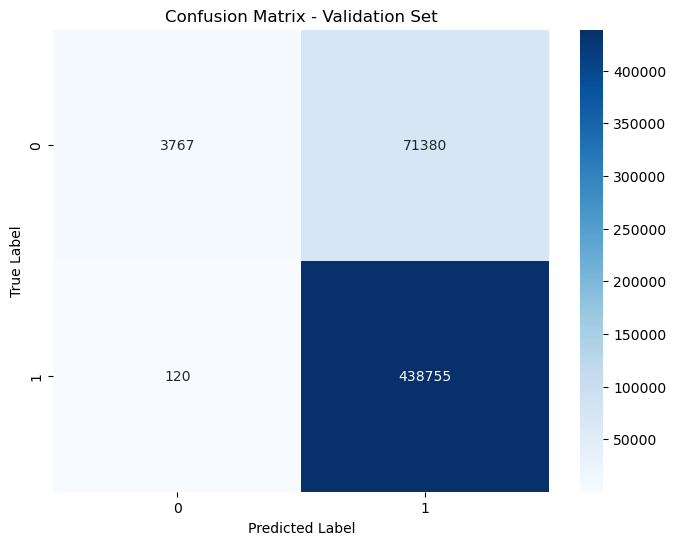

In [67]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_val_pred_binary), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

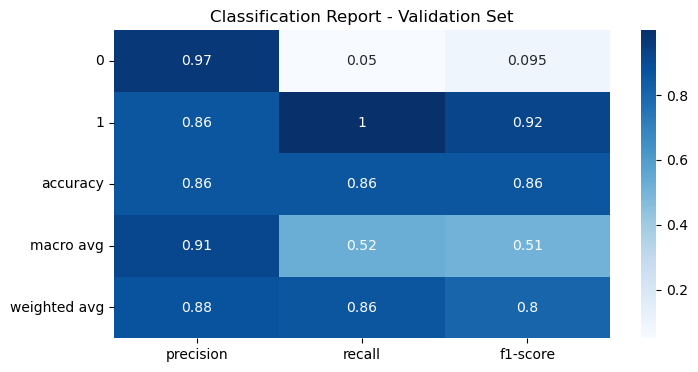

In [68]:
# Classification Report Plot
plt.figure(figsize=(8, 4))
sns.heatmap(pd.DataFrame(classification_report(y_val, y_val_pred_binary, output_dict=True)).iloc[:-1].T, annot=True, cmap='Blues')
plt.title('Classification Report - Validation Set')
plt.show()

In [69]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

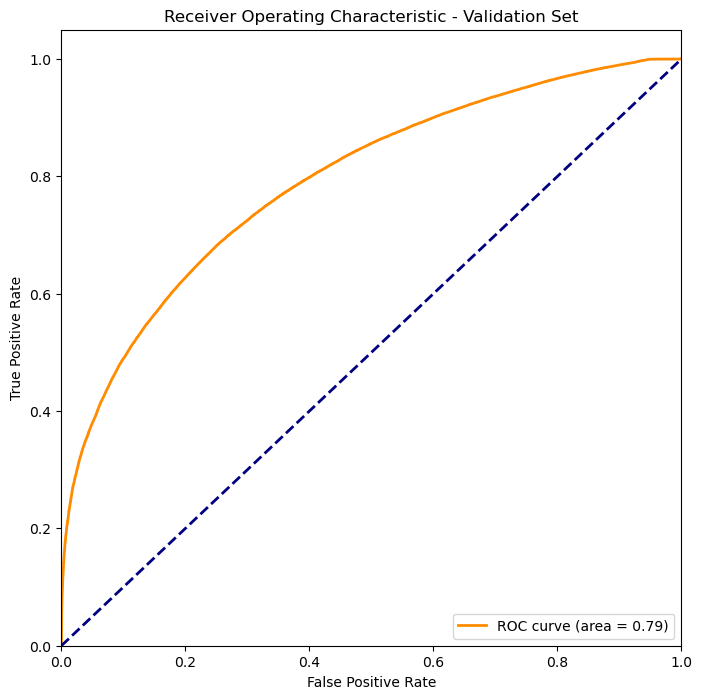

In [70]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

In [71]:
# Visualize model predictions on the test set
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

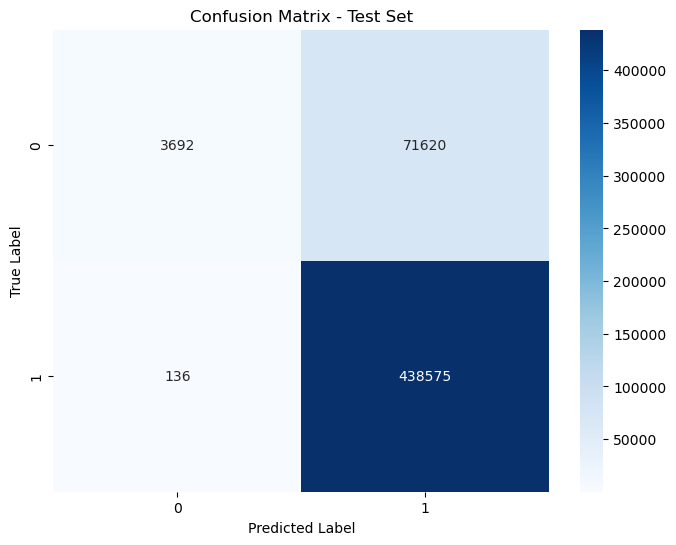

In [72]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_binary), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

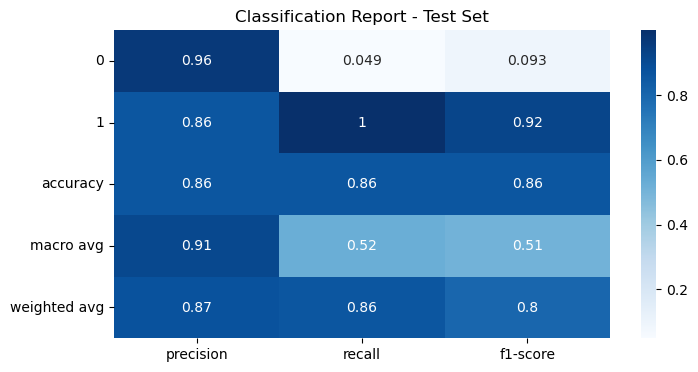

In [73]:
# Classification Report Plot
plt.figure(figsize=(8, 4))
sns.heatmap(pd.DataFrame(classification_report(y_test, y_test_pred_binary, output_dict=True)).iloc[:-1].T, annot=True, cmap='Blues')
plt.title('Classification Report - Test Set')
plt.show()

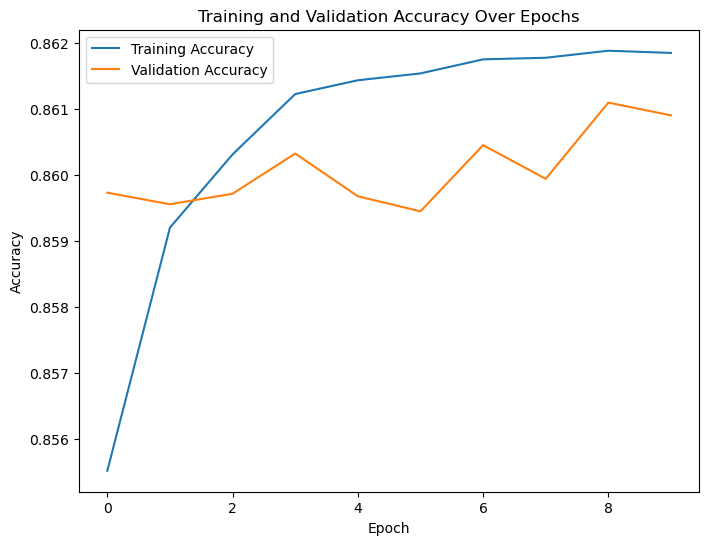

In [79]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [80]:
cnn_accuracy = history_cnn.history['val_accuracy'][-1]
bi_lstm_accuracy = history_dropout.history['val_accuracy'][-1]

In [82]:
models = ['CNN', 'Bi-LSTM']
accuracies = [cnn_accuracy, bi_lstm_accuracy]

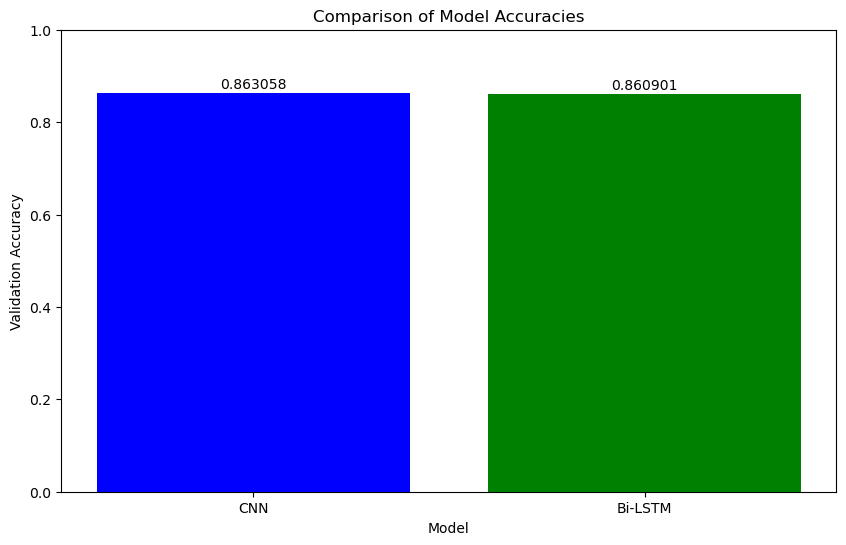

In [85]:
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])

for i in range(len(models)):
    plt.text(i, accuracies[i] + 0.01, f'{accuracies[i]:.6f}', ha='center')

plt.show()

Accuracies for both model are almost identical